In [1]:
import igraph
import json
import os
import csv
import pandas as pd

## Q6

### (1) extract data

In [2]:
os.chdir("/Users/bournsh/Desktop/UCLA_Studying/2020spring/ECE232/Project4/data/test_data")

In [3]:
data = pd.read_csv("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv", sep = ",", header = [0])

In [4]:
data.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,1982,73,12,350.59,230.08,311.46,1.56
1,2213,1523,12,872.92,383.89,803.50,1.49
2,438,433,12,2262.35,919.08,2144.34,1.35
3,448,333,12,1337.10,431.10,1277.05,1.35
4,1044,1015,10,690.68,282.61,634.03,1.58


In [5]:
data_meanTime_month = data.iloc[:,0:4]

In [6]:
data_meanTime_month.head()

,sourceid,dstid,month,mean_travel_time
0,1982,73,12,350.59
1,2213,1523,12,872.92
2,438,433,12,2262.35
3,448,333,12,1337.10
4,1044,1015,10,690.68


In [7]:
data_meanTime_Dec = data_meanTime_month.loc[data_meanTime_month["month"] == 12]

In [8]:
data_meanTime_Dec.head()

,sourceid,dstid,month,mean_travel_time
0,1982,73,12,350.59
1,2213,1523,12,872.92
2,438,433,12,2262.35
3,448,333,12,1337.10
6,2231,315,12,805.52


In [9]:
data_meanTime_Dec = data_meanTime_Dec.iloc[:,[0,1,3]]

### (2) create a dataframe to get ready for the graph creation and then create a graph

In [10]:
data_meanTime_Dec.head()

,sourceid,dstid,mean_travel_time
0,1982,73,350.59
1,2213,1523,872.92
2,438,433,2262.35
3,448,333,1337.10
6,2231,315,805.52


In [11]:
data_meanTime_Dec["sourceid"] = data_meanTime_Dec["sourceid"].astype(str)
data_meanTime_Dec["dstid"] = data_meanTime_Dec["dstid"].astype(str)

In [12]:
data_meanTime_Dec.head()

,sourceid,dstid,mean_travel_time
0,1982,73,350.59
1,2213,1523,872.92
2,438,433,2262.35
3,448,333,1337.10
6,2231,315,805.52


In [13]:
type(data_meanTime_Dec.iloc[1,0])

str

In [14]:
# create a graph from the data_meanTime_Dec dataframe
tuples = [tuple(x) for x in data_meanTime_Dec.values]
g = igraph.Graph.TupleList(tuples, directed = False, edge_attrs = ["mean_travel_time"])

### (3) extract Geo json data

In [15]:
with open("san_francisco_censustracts.json", "r") as f:
    data_json = json.load(f)

In [16]:
data_json["type"]

'FeatureCollection'

In [17]:
geo_data = data_json["features"]

In [18]:
# create an empty dataframe
col_names = ["ID", "Display_Name", "Logitude", "Latitude"]
id_to_coordinate = pd.DataFrame(columns = col_names)

In [19]:
id_to_coordinate.loc[0,"ID"]=1

In [20]:
id_to_coordinate

,ID,Display_Name,Logitude,Latitude
0,1,NaN,NaN,NaN


In [21]:
i = 0

for feature in geo_data:
    id_to_coordinate.loc[i,"ID"] = feature["properties"]["MOVEMENT_ID"]
    id_to_coordinate.loc[i,"Display_Name"] = feature["properties"]["DISPLAY_NAME"]
    
    coordinates = feature["geometry"]["coordinates"][0][0]
    if isinstance(coordinates[0], list):
        latitude = 0
        longitude = 0
        for coordinate in coordinates:
            longitude = longitude + coordinate[0]
            latitude = latitude + coordinate[1]

        longitude = longitude/len(coordinates)
        latitude = latitude/len(coordinates)
    else:
        coordinates = feature["geometry"]["coordinates"][0]
        latitude = 0
        longitude = 0
        for coordinate in coordinates:
            longitude = longitude + coordinate[0]
            latitude = latitude + coordinate[1]

        longitude = longitude/len(coordinates)
        latitude = latitude/len(coordinates)
        
    id_to_coordinate.loc[i,"Latitude"] = latitude
    id_to_coordinate.loc[i,"Logitude"] = longitude
    i = i+1


In [22]:
id_to_coordinate.head()

,ID,Display_Name,Logitude,Latitude
0,1,"Sargent Creek, San Ardo",-120.789,36.0716
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...",-122.219,37.4696
2,3,"18300 Sutter Boulevard, Morgan Hill",-121.66,37.1505
3,4,"2700 Stoughton Way, Sheffield, Sacramento",-121.343,38.5731
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento",-121.362,38.5544


In [23]:
print(len(g.vs()))
print(g.vs)

1905


In [24]:
print((id_to_coordinate.loc[id_to_coordinate["ID"] == "1"]).iloc[:,1].values[0])
id_to_coordinate.loc[id_to_coordinate["ID"] == "1"].iloc[:,1].values[0]

Sargent Creek, San Ardo


'Sargent Creek, San Ardo'

### (4) map the coordinates from the Geo data to the vertices of the graph

In [25]:
gVertexSeq = g.vs()
for v in gVertexSeq:
    v["Display_Name"] = id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,1].values[0]
    v["Coordinate"] = (id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,2].values[0],
                       id_to_coordinate.loc[id_to_coordinate["ID"] == v['name']].iloc[:,3].values[0])

In [26]:
print(g.vs[1904]["Coordinate"])
print(g.vs[1904]["name"])

(-122.66583117142855, 37.92502968571428)
1122


In [27]:
id_to_coordinate.loc[1121]

ID                                         1122
Display_Name    4700 Shoreline Highway, Bolinas
Logitude                               -122.666
Latitude                                 37.925
Name: 1121, dtype: object

In [28]:
len(gVertexSeq)

1905

In [29]:
# summary print out the attributes of the graph
# there are 4 attributes, the first three is the attributes for the vertices
# the last one is the attribute for the edges, that is the weights of the edges
g_giant = g.components().giant()
igraph.summary(g_giant)

IGRAPH UN-- 1898 555250 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), mean_travel_time (e)


In [30]:
len(g_giant.vs())

1898

## Q7

In [31]:
g_giant_mst = g_giant.spanning_tree(weights = g_giant.es["mean_travel_time"])

In [32]:
mst_VertexSeq = g_giant_mst.vs()

In [33]:
last_idx = len(mst_VertexSeq)-1

In [34]:
import random
r = random.randint(0, len(mst_VertexSeq))
for i in range(6):
    r = random.randint(0, len(mst_VertexSeq))
    print("Random point{}:".format(i+1))
    print("One endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[r]["name"], mst_VertexSeq[r]["Display_Name"]))
    print("Coordinate: {}".format(mst_VertexSeq[r]["Coordinate"]))
    print("Another endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[r+1]["name"], mst_VertexSeq[r+1]["Display_Name"]))
    print("Coordinate: {}\n".format(mst_VertexSeq[r+1]["Coordinate"]))

Random point1:
One endpoint:
ID: 2343, Display_Name: West Point Road, Bayview, San Francisco
Coordinate: (-122.37610630952378, 37.73504938095237)
Another endpoint:
ID: 1739, Display_Name: 0 Reiner Street, Daly City
Coordinate: (-122.46566652, 37.687703840000005)

Random point2:
One endpoint:
ID: 1624, Display_Name: 2900 Roosevelt Lane, Antioch
Coordinate: (-121.79682482758622, 37.99054496551724)
Another endpoint:
ID: 414, Display_Name: Fallman Road, Brentwood
Coordinate: (-121.59166960227276, 37.93368540909092)

Random point3:
One endpoint:
ID: 2516, Display_Name: 1800 Barrett Avenue, Morgan Hill
Coordinate: (-121.6026775135135, 37.13491705405406)
Another endpoint:
ID: 74, Display_Name: 300 West Humboldt Street, Central San Jose, San Jose
Coordinate: (-121.8815286, 37.3160018)

Random point4:
One endpoint:
ID: 2236, Display_Name: San Francisco Bay Trail, Hayward
Coordinate: (-122.11248918181822, 37.61121337500001)
Another endpoint:
ID: 253, Display_Name: 1000 Shasta Street, Vallejo
Coo

In [35]:
print("First endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[0]["name"], mst_VertexSeq[0]["Display_Name"]))
print("Coordinate: {}\n".format(mst_VertexSeq[0]["Coordinate"]))

First endpoint:
ID: 1982, Display_Name: 100 Monte Verde Drive, Vacaville
Coordinate: (-122.00124636111111, 38.352439888888895)



In [36]:
print("Second endpoint:\nID: {}, Display_Name: {}".format(mst_VertexSeq[1]["name"], mst_VertexSeq[1]["Display_Name"]))
print("Coordinate: {}\n".format(mst_VertexSeq[1]["Coordinate"]))

Second endpoint:
ID: 73, Display_Name: 2100 Fieldcrest Avenue, Fairfield
Coordinate: (-122.05216156249999, 38.292827187500016)



## Q11

In [37]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

In [38]:
id_to_coordinate.head()

,ID,Display_Name,Logitude,Latitude
0,1,"Sargent Creek, San Ardo",-120.789,36.0716
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...",-122.219,37.4696
2,3,"18300 Sutter Boulevard, Morgan Hill",-121.66,37.1505
3,4,"2700 Stoughton Way, Sheffield, Sacramento",-121.343,38.5731
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento",-121.362,38.5544


In [39]:
coordinates_df = id_to_coordinate.iloc[:,[2,3]]
coordinates_df.head()

,Logitude,Latitude
0,-120.789,36.0716
1,-122.219,37.4696
2,-121.66,37.1505
3,-121.343,38.5731
4,-121.362,38.5544


In [40]:
len(coordinates_df)

2710

In [41]:
coordinates_df.iloc[0,0]

-120.78868462095731

In [42]:
type(np.array([coordinates_df.iloc[0,0], coordinates_df.iloc[0,1]]))

numpy.ndarray

In [43]:
a = np.zeros((2))
a[0] = 1
a

array([1., 0.])

In [44]:
coordinates_list = []
for i in range(len(coordinates_df)):
    coordinates_list.append([coordinates_df.iloc[i,0], coordinates_df.iloc[i,1]])
coordinates_array = np.array(coordinates_list)

In [45]:
tri = Delaunay(coordinates_array)

In [46]:
tri.simplices

array([[ 247, 2662,  796],
       [ 204,  247,  629],
       [ 247,  204, 2614],
       ...,
       [ 612,  809, 1536],
       [ 809, 1061, 1536],
       [ 809, 1535, 1061]], dtype=int32)

In [47]:
triangle_idx_array = []
for triangle in tri.simplices:
    for idx in triangle:
        triangle_idx_array.append(idx)
len(triangle_idx_array)

16218

In [48]:
min(triangle_idx_array)

0

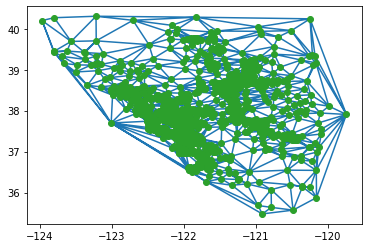

In [49]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices)
plt.plot(x, y, 'o')
plt.show()

In [50]:
a = (1,2)
b = list(a)
b

[1, 2]

In [51]:
coordinates_list = []
gVertexSeq = g_giant.vs()
for v in gVertexSeq:
    coordinates_list.append(list(v["Coordinate"]))
coordinates_array = np.array(coordinates_list)

In [52]:
tri = Delaunay(coordinates_array)

In [53]:
tri.simplices

array([[ 693, 1881, 1857],
       [1883, 1807, 1424],
       [1206,  693, 1857],
       ...,
       [ 417, 1078,  668],
       [1078, 1371,  668],
       [1078,  498, 1371]], dtype=int32)

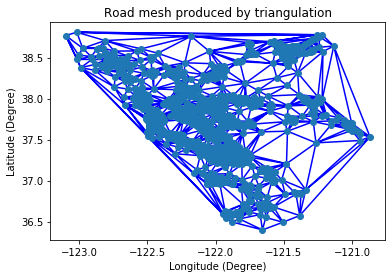

In [54]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.title("Road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.plot(x, y, 'o')
plt.show()

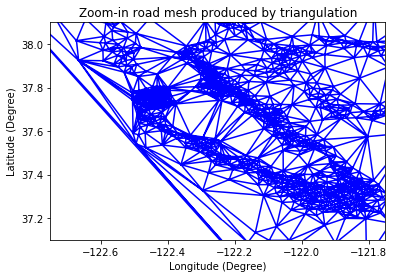

In [55]:
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.title("Zoom-in road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
#plt.plot(x, y, 'o')
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.show()

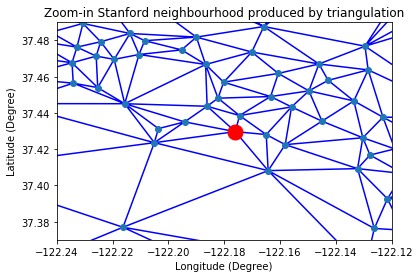

In [56]:
# (-122.1759822222222, 37.42968588888888)
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in Stanford neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 30)
plt.show()

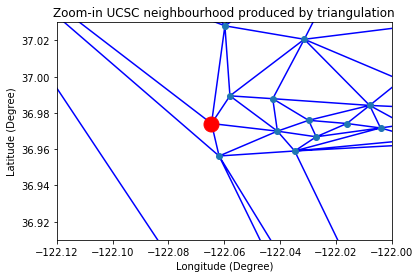

In [57]:
# (-122.06456181081083, 36.97416881081081)
x = tri.points[:,0]
y = tri.points[:,1]
plt.triplot(x, y, tri.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in UCSC neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 30)
plt.show()

## Q12

In [58]:
from scipy.spatial import distance

In [59]:
g_giant.vs[1]["Coordinate"]

(-122.05216156249999, 38.292827187500016)

In [60]:
a = (1,2)
b = (3,4)
dist = distance.euclidean(a,b)
dist

2.8284271247461903

In [61]:
def calculate_flow(dist, time):
    speed = dist/time
    flow = 2/(0.003/speed + 1/1800)
    return flow    

In [62]:
# calculate the flow for each edge and add an attribute flow to each edge
g_giant_flow = g_giant
gcc_EdgeSeq = igraph.EdgeSeq(g_giant_flow)
i = 0
for es in gcc_EdgeSeq:
    vertex_id_1 = es.tuple[0]
    vertex_id_2 = es.tuple[1]
    coordinate_1 = g_giant.vs[vertex_id_1]["Coordinate"]
    coordinate_2 = g_giant.vs[vertex_id_2]["Coordinate"]
    dist = 69*distance.euclidean(coordinate_1, coordinate_2) # each degree of latitude and longitude is about 69 miles
    time = es["mean_travel_time"]/3600 # convert second to hour
    if dist == 0:
        continue
    flow = calculate_flow(dist, time)
    es["Flow"] = flow
    i = i+1
    
g_giant_flow.summary()

'IGRAPH UN-- 1898 555250 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), mean_travel_time (e)'

In [63]:
igraph.EdgeSeq(g_giant)[2251].tuple

(1150, 1150)

In [64]:
gcc_EdgeSeq[10]["Flow"]

3265.7845351465344

In [65]:
16%2

0

In [68]:
#print the flow for all the edges
i = 1
for es in gcc_EdgeSeq:
    if es["Flow"] is not None:
        flow = es["Flow"]
    else:
        i = i+1
        continue
        
#     if i % 12 == 0:
#         print("{:.0f}\n".format(flow), end = "")
#     else:
#         print("{:.0f}\t".format(flow), end = "")
    i = i+1

In [69]:
# mean of the flow
flow_total = 0
n = 0
for es in gcc_EdgeSeq:
    if es["Flow"] is not None:
        flow_total += es["Flow"]
        n += 1
    else:        
        continue
flow_mean = flow_total/n
print("The mean of the flow is {:.0f} cars/(hour.road)".format(flow_mean))

The mean of the flow is 2996 cars/(hour.road)


## Q13

In [70]:
id_to_coordinate.head()

,ID,Display_Name,Logitude,Latitude
0,1,"Sargent Creek, San Ardo",-120.789,36.0716
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...",-122.219,37.4696
2,3,"18300 Sutter Boulevard, Morgan Hill",-121.66,37.1505
3,4,"2700 Stoughton Way, Sheffield, Sacramento",-121.343,38.5731
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento",-121.362,38.5544


In [71]:
ggcVertexSeq = g_giant_flow.vs()
for i in range(len(g_giant.vs())):
    if g_giant_flow.vs[i]["Display_Name"] == "100 Campus Drive, Stanford":
        source_vertex_id = i
    elif g_giant_flow.vs[i]["Display_Name"] == "700 Meder Street, Santa Cruz":
        destination_vertex_id = i

In [72]:
g_giant_flow.vs[1]["Display_Name"]

'2100 Fieldcrest Avenue, Fairfield'

In [73]:
source_vertex_id=1614
destination_vertex_id=868

In [74]:
g_giant_flow.vs[source_vertex_id]

igraph.Vertex(<igraph.Graph object at 0x7fed15f25d50>, 1614, {'name': '846', 'Display_Name': '300 Homestead Avenue, Salinas', 'Coordinate': (-121.66435007142856, 36.670510285714286)})

In [75]:
g_giant_flow.vs[destination_vertex_id]

igraph.Vertex(<igraph.Graph object at 0x7fed15f25d50>, 868, {'name': '2000', 'Display_Name': '200 Genoa Court, Vallejo', 'Coordinate': (-122.22766157894735, 38.14841894736842)})

In [76]:
#g_giant_flow.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

In [77]:
# For undirected graphs this entry is bit trickier, since for these the flow direction is not predetermined by 
# the edge direction. For these graphs the elements of the this vector can be negative, this means that the flow 
# goes from the bigger vertex id to the smaller one. Positive values mean that the flow goes from the smaller vertex 
# id to the bigger one.
# Ford-Fulkerson Algorithm 
# https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/
# https://www.hackerearth.com/practice/algorithms/graphs/maximum-flow/tutorial/
ggc_maxflow = g_giant_flow.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

In [78]:
ggc_maxflow_value = g_giant_flow.maxflow_value(source_vertex_id, destination_vertex_id, capacity = "Flow")

In [79]:
print("The maxflow value is {}".format(ggc_maxflow_value))

The maxflow value is 220354.81816238968


In [80]:
# The edge connectivity between two given vertices is the number of edges that have to be removed in order to 
# disconnect the two vertices into two separate components. This is also the number of edge disjoint directed paths 
# between the vertices. The edge connectivity of the graph is the minimal edge connectivity over all vertex pairs.
# The edge connectivity between two given vertices is the number of edges that have to be removed in order to 
# disconnect the two vertices into two separate components. This is also the number of edge disjoint directed paths 
# between the vertices. The edge connectivity of the graph is the minimal edge connectivity over all vertex pairs.
# https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/edgedisjoint.pdf
gcc_edge_disjoint_paths = g_giant_flow.edge_disjoint_paths(source_vertex_id, destination_vertex_id)

In [81]:
print("The number of edge-disjoint paths is {}".format(gcc_edge_disjoint_paths))

The number of edge-disjoint paths is 78


## Q14

### (1) remove edges to prune the triangulation graph

In [82]:
tri.simplices[0]

array([ 693, 1881, 1857], dtype=int32)

In [83]:
a = [1,2,3]
print(set((1,2)) == set((2,1)))
print((1,2) == (2,1))

True
False


In [84]:
d = set()
d.add(1)
d.add(1)
d

{1}

In [85]:
print(type(tri.simplices))
print(type(tri.simplices[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [86]:
# Delaunay triangulation might generate some edges that are not in the graph
# check all the edges of all the triangles generated by Delaunay
# If the edge is not in the the edgelist of the graph
# Or if the edge mean_travel_time is lower than the set THRESHOLD
# Then remove this edge
# tri.simplices return the triangle arrays, each array have the 3 vertex indeces
# which corresponds to the vertex id in the graph object
# use set to compare, because set doesn't have order 

# iterate triangulation edges, to avoid duplicate, use the hashset
triangles = tri.simplices
triangles_set = set()

for triangle in triangles:
    a = (triangle[0], triangle[1])
    b = (triangle[1], triangle[2])
    c = (triangle[2], triangle[0])
    triangles_set.add(a)
    triangles_set.add(b)
    triangles_set.add(c)      


In [87]:
# convert EdgeSeq to hashdict to facilitate edge finding
gcc_EdgeSeq = igraph.EdgeSeq(g_giant)
edge_to_time = {}
for es in gcc_EdgeSeq:
    edge_to_time[es.tuple] = es["mean_travel_time"]
    
len(edge_to_time)

321703

In [88]:
edge_idx_array = []
for es in gcc_EdgeSeq:
    edge_idx_array.append(es.tuple[0])
    edge_idx_array.append(es.tuple[1])
print(min(edge_idx_array))
print(max(edge_idx_array))

0
1897


In [89]:
#edge_to_time

In [90]:
# convert EdgeSeq to hashset to facilitate edge finding
edge_set = set()
for es in gcc_EdgeSeq:
    edge_set.add(es.tuple)
    
len(edge_set)

321703

In [91]:
#edge_set

In [92]:
#triangles_set

In [93]:
# check if the triangulation edges are in the EdgeSeq
# note that AB and BA are the same edge
new_triEdge_to_time = {}
for tri_edge in triangles_set:        
    time_temp = edge_to_time.get(tri_edge)
    if time_temp:
        new_triEdge_to_time[tri_edge] = time_temp
    else:
        edge_reverse = tuple((tri_edge[1], tri_edge[0]))
        time_temp = edge_to_time.get(edge_reverse)
        if time_temp:
            new_triEdge_to_time[edge_reverse] = time_temp

len(new_triEdge_to_time)

5288

In [94]:
type(new_triEdge_to_time.values())

dict_values

In [95]:
np.array(list(new_triEdge_to_time.values())).mean()

264.16299735249623

In [96]:
#new_triEdge_to_time

In [97]:
# check the triangulation edges in the new_triEdge_to_time dictionary are lower than the THRESHOLD
THRESHOLD = 600

# to avoid changing dictionary size during iterateration which is not allowed b/c items return the iterators
# create a new dictionary and add item into it
threshold_triEdge_to_time = {}
for edge_key, edge_time in new_triEdge_to_time.items():
    if edge_time < THRESHOLD:
        threshold_triEdge_to_time[edge_key] = edge_time
        
len(threshold_triEdge_to_time)

4962

In [98]:
#threshold_triEdge_to_time

In [99]:
print("The number of edges after triangulation: {}".format(len(triangles_set)))
print("The number of edges after triangulation also in the edgelist: {}".format(len(new_triEdge_to_time)))
print("The number of edges after pruning (in the edgelist also within threshold): {}".format(len(threshold_triEdge_to_time)))

The number of edges after triangulation: 11349
The number of edges after triangulation also in the edgelist: 5288
The number of edges after pruning (in the edgelist also within threshold): 4962


### (2) create the pruned graph

In [100]:
# convert the dictionary to a dataframe to get ready for the graph creation
col_names = ["V1", "V2", "mean_travel_time"]
triEdge_df = pd.DataFrame(columns = col_names)

i = 0
for edge_key, edge_time in threshold_triEdge_to_time.items():
    triEdge_df.loc[i,"V1"] = str(edge_key[0])
    triEdge_df.loc[i,"V2"] = str(edge_key[1])
    triEdge_df.loc[i,"mean_travel_time"] = edge_time
    i = i+1

In [101]:
triEdge_df.head()

,V1,V2,mean_travel_time
0,978,1649,328.1
1,808,994,419.55
2,137,458,342.59
3,522,1630,321.09
4,394,507,166.48


In [102]:
len(triEdge_df)

4962

In [103]:
# create a graph from the data_meanTime_Dec dataframe
tuples_prune = [tuple(x) for x in triEdge_df.values]
g_giant_prune = igraph.Graph.TupleList(tuples_prune, directed = False, edge_attrs = ["mean_travel_time"])

In [104]:
g_giant_prune.summary()

'IGRAPH UN-- 1887 4962 -- \n+ attr: name (v), mean_travel_time (e)'

In [105]:
g_giant_prune.vs[0]["name"]

'978'

### (3) add coordinates attributes to the pruned graph

In [106]:
# from Q11 
# coordinates extracted from the Geo json file
# dataframe of coordinates of different vertex indices
coordinates_df.head()

,Logitude,Latitude
0,-120.789,36.0716
1,-122.219,37.4696
2,-121.66,37.1505
3,-121.343,38.5731
4,-121.362,38.5544


In [107]:
id_to_coordinate.head()

,ID,Display_Name,Logitude,Latitude
0,1,"Sargent Creek, San Ardo",-120.789,36.0716
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...",-122.219,37.4696
2,3,"18300 Sutter Boulevard, Morgan Hill",-121.66,37.1505
3,4,"2700 Stoughton Way, Sheffield, Sacramento",-121.343,38.5731
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento",-121.362,38.5544


In [108]:
coordinates_df.iloc[0,1]

36.07162944372576

In [109]:
# Denaulay for Q11 is constructed from the graph, for the index, point1 for Denaulay is the point1 in g_giant
# on the graph g_giant ["name"] attribute is +1 over the index
# g_giant ["name"] = g_giant_prune ["name"] = Denaulay index have the same meaning
# index in the coordinates_df = g_giant ["name"]-1
# index NOT equal to ["name"]

gVertexSeq_prune = g_giant_prune.vs()
gVertexSeq = g_giant.vs()
for v in gVertexSeq_prune:
    idx_in_coordinatesDF = int(v["name"])-1
    v["Coordinate"] = (id_to_coordinate.iloc[idx_in_coordinatesDF, 2],
                       id_to_coordinate.iloc[idx_in_coordinatesDF, 3])
    v["Display_Name"] = id_to_coordinate.iloc[idx_in_coordinatesDF, 1]

In [110]:
igraph.summary(g_giant_prune)

IGRAPH UN-- 1887 4962 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), mean_travel_time (e)


In [111]:
g_giant_prune.vs[0]["Display_Name"]

'7600 Wilbur Way, Sacramento'

In [112]:
len(gVertexSeq_prune)

1887

### (4) pruned graph Delaunay

In [113]:
# coordinates_array_prune for the pruned graph
coordinates_list_prune = []
gVertexSeq_prune = g_giant_prune.vs()
for v in gVertexSeq_prune:
    coordinates_list_prune.append(list(v["Coordinate"]))
coordinates_array_prune = np.array(coordinates_list_prune)

In [114]:
coordinates_array_prune

array([[-121.39841818,   38.47701845],
       [-122.4678544 ,   37.7630497 ],
       [-122.28026054,   37.82362231],
       ...,
       [-122.07977253,   37.3898666 ],
       [-121.06561431,   38.9825281 ],
       [-122.09853717,   37.35385625]])

In [115]:
tri_prune = Delaunay(coordinates_array_prune)

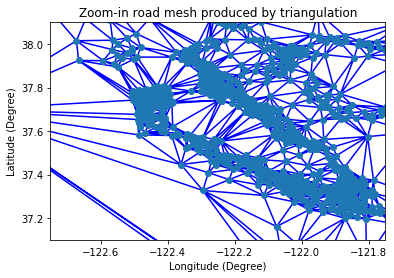

In [116]:
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in road mesh produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.show()

### (5) plot zoom-in graph

In [117]:
# convert to dictionary, b/c dictionary dict.get(key) search complexity is O(1)
displayName_to_coordinate = {}
n = len(id_to_coordinate)
for i in range(n):
    displayName_to_coordinate[id_to_coordinate.iloc[i,1]] = ((id_to_coordinate.iloc[i,2]),(id_to_coordinate.iloc[i,3]))
    

In [118]:
#displayName_to_coordinate

In [119]:
displayName_to_coordinate.get("100 Campus Drive, Stanford")

(-122.1759822222222, 37.42968588888888)

In [120]:
displayName_to_coordinate.get("700 Meder Street, Santa Cruz")

(-122.06456181081083, 36.97416881081081)

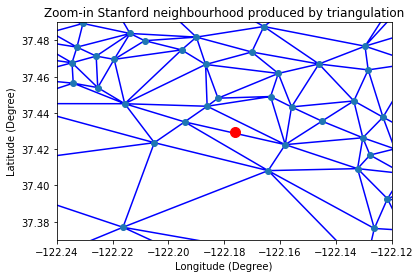

In [121]:
# (-122.1759822222222, 37.42968588888888)
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in Stanford neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 20)
plt.show()

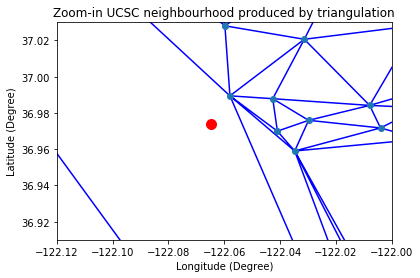

In [122]:
# (-122.06456181081083, 36.97416881081081)
x = tri_prune.points[:,0]
y = tri_prune.points[:,1]
plt.triplot(x, y, tri_prune.simplices, color = "b")
plt.plot(x, y, 'o')
plt.title("Zoom-in UCSC neighbourhood produced by triangulation")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 20)
plt.show()

### (6) plot pruned graph

In [123]:
# from Q11 
# coordinates extracted from the Geo json file
# dataframe of coordinates of different vertex indices
coordinates_df.head()

,Logitude,Latitude
0,-120.789,36.0716
1,-122.219,37.4696
2,-121.66,37.1505
3,-121.343,38.5731
4,-121.362,38.5544


In [124]:
coordinates_df.iloc[0,1]

36.07162944372576

In [125]:
threshold_triEdge_to_time

{(978, 1649): 328.1,
 (808, 994): 419.55,
 (137, 458): 342.59,
 (522, 1630): 321.09,
 (394, 507): 166.48,
 (375, 590): 189.13,
 (514, 1087): 361.5,
 (462, 1120): 226.71,
 (1248, 1283): 196.35,
 (239, 1312): 291.92,
 (834, 1075): 410.19,
 (74, 449): 50.22,
 (9, 345): 251.29,
 (1506, 1626): 266.85,
 (842, 1247): 209.34,
 (1706, 1764): 388.57,
 (777, 1696): 339.66,
 (408, 1085): 173.6,
 (1657, 1674): 314.39,
 (1093, 1130): 211.66,
 (1187, 1517): 231.84,
 (1225, 1611): 501.95,
 (198, 478): 160.85,
 (58, 496): 282.9,
 (522, 1396): 183.48,
 (1394, 1490): 96.21,
 (61, 974): 161.04,
 (63, 297): 104.24,
 (1647, 1812): 99.8,
 (848, 1292): 84.62,
 (511, 1712): 161.75,
 (1310, 1396): 420.66,
 (509, 1402): 147.49,
 (204, 1627): 228.7,
 (378, 933): 224.77,
 (1286, 1293): 121.29,
 (1055, 1467): 186.21,
 (275, 1289): 231.22,
 (145, 611): 72.68,
 (1152, 1249): 269.9,
 (1325, 1330): 222.5,
 (738, 1620): 150.64,
 (890, 1267): 308.76,
 (174, 992): 364.57,
 (115, 624): 330.44,
 (1145, 1769): 290.53,
 (148,

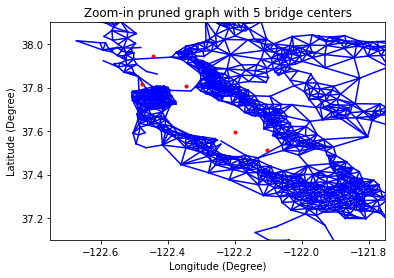

In [126]:
plt.figure()
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")

plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))


# add centers of the bridges
center_1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
center_2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
center_3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
center_4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
center_5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

centers = np.array([center_1, center_2, center_3, center_4, center_5])
plt.plot(centers[:,0], centers[:,1], 'r.')
plt.title("Zoom-in pruned graph with 5 bridge centers")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.show()


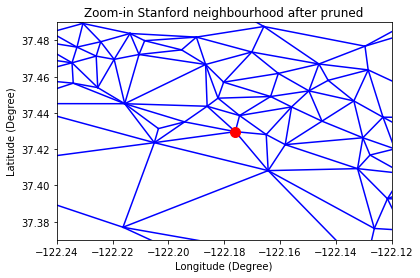

In [127]:
# (-122.1759822222222, 37.42968588888888)
# zoom in Stanford
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")
    

plt.title("Zoom-in Stanford neighbourhood after pruned")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((37.43-0.06,37.43+0.06))
plt.xlim((-122.18-0.06,-122.18+0.06))

plt.plot(-122.1759822222222, 37.42968588888888, 'r.', ms = 20)
plt.show()

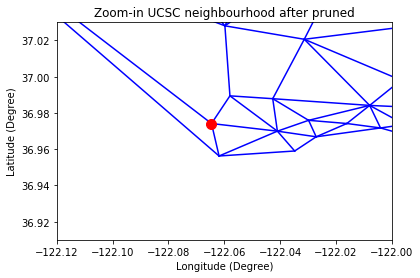

In [128]:
# (-122.06456181081083, 36.97416881081081)
# zoom in UCSC
gVertexSeq = g_giant.vs()
for edge_key in threshold_triEdge_to_time:
    point1_idx = edge_key[0]
    point1_idx_original = int(gVertexSeq[point1_idx]["name"])-1
    point1_coordinate = [coordinates_df.iloc[point1_idx_original,0], coordinates_df.iloc[point1_idx_original,1]]
    point2_idx = edge_key[1]
    point2_idx_original = int(gVertexSeq[point2_idx]["name"])-1
    point2_coordinate = [coordinates_df.iloc[point2_idx_original,0], coordinates_df.iloc[point2_idx_original,1]]
    
    points = np.array([point1_coordinate, point2_coordinate])
    plt.plot(points[:,0], points[:,1], color = "b")
    

plt.title("Zoom-in UCSC neighbourhood after pruned")
plt.ylabel("Latitude (Degree)")
plt.xlabel("Longitude (Degree)")
plt.ylim((36.97-0.06,36.97+0.06))
plt.xlim((-122.06-0.06,-122.06+0.06))

plt.plot(-122.06456181081083, 36.97416881081081, 'r.', ms = 20)
plt.show()

In [129]:
coordinates_df.iloc[74,0]

-122.46411223076923

In [130]:
EdgeSeq_prune = igraph.EdgeSeq(g_giant_prune)
EdgeSeq_prune[0].tuple

(0, 1)

(-122.75, -121.75)

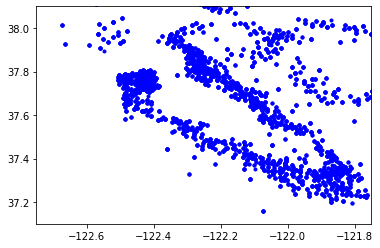

In [131]:
plt.figure()
EdgeSeq_prune = igraph.EdgeSeq(g_giant_prune)
VetexSeq_prune = g_giant_prune.vs()
for es in EdgeSeq_prune:
    v1_idx = es.tuple[0]
    v2_idx = es.tuple[1]
    v1_coordinate = VetexSeq_prune[v1_idx]["Coordinate"]
    v2_coordinate = VetexSeq_prune[v2_idx]["Coordinate"]
    points = np.array([v1_coordinate, v2_coordinate])
    plt.plot(points[:,0], points[:,1], "b.")

plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))

In [132]:
for edge_key in threshold_triEdge_to_time:
    x_idx = edge_key[0]
    x = [coordinates_df.iloc[x_idx,0], coordinates_df.iloc[x_idx,1]]
    y_idx = edge_key[1]
    y = [coordinates_df.iloc[y_idx,0], coordinates_df.iloc[y_idx,1]]
    print(x,y)

[-121.29664763636364, 37.99817263636363] [-122.47017734999997, 37.752123600000004]
[-122.24890423076924, 37.817374] [-120.47588020618562, 36.87490118556702]
[-122.61891066666665, 38.25354376666666] [-122.24104264285712, 37.79130535714285]
[-121.29196078571428, 37.96394500000001] [-121.92815610909089, 37.76575067272727]
[-122.22529319230767, 37.45399473076923] [-121.45146594117648, 38.530277647058824]
[-121.02396189999999, 37.675258450000015] [-122.23789377777777, 37.80058011111112]
[-121.30063553333333, 38.657123999999996] [-122.1568991875, 37.732926437500005]
[-122.26893463636365, 37.86807690909091] [-122.5482637631579, 37.89476132894737]
[-121.78720288000001, 37.3065382] [-121.87793664285714, 37.383797785714286]
[-121.78432372222223, 36.95744969444446] [-123.09819497235014, 38.76923599539172]
[-121.7694892, 38.67038599999999] [-121.00719763709675, 38.7360674919355]
[-122.46411223076923, 38.280859807692316] [-121.10623145454547, 38.6722194090909]
[-121.06001984615384, 37.6941770769230

[-122.295348, 37.79755076923077] [-122.17301338888888, 37.75306666666667]
[-122.35656119770778, 39.10059647564475] [-121.89882746153846, 37.42116080769232]
[-122.17959432467536, 37.90400679220779] [-122.44282744444445, 37.71948722222222]
[-122.11239666666667, 37.97128684210527] [-122.36013135151514, 37.4462464]
[-122.29155535, 37.905107799999996] [-120.88047683636363, 38.288668193939344]
[-121.35901868965517, 38.64735686206897] [-122.12478551724139, 37.69882548275861]
[-121.3170205625, 38.4290795625] [-121.36657995, 38.565346500000004]
[-122.0347427777778, 36.95901055555556] [-123.15296847403461, 38.582017342210314]
[-121.90507255555556, 37.43876933333334] [-121.7900085651163, 38.969018420930226]
[-121.03332492307693, 37.656768846153845] [-122.49114293939391, 37.67702869696971]
[-121.25448665909094, 37.91756706818183] [-121.43155845000001, 38.622042650000004]
[-122.49141055555555, 37.940304999999995] [-121.38040362962964, 36.843972666666666]
[-121.88373180392156, 37.7703477254902] [-12

[-120.16229077083331, 36.54218973958334] [-121.88748899999999, 37.705987071428574]
[-122.01825252631579, 37.570302052631575] [-120.69106570953439, 39.79978487139689]
[-122.14071842857145, 38.02277771428572] [-121.8413663, 37.3653341]
[-122.54534531698114, 38.218784641509465] [-121.42911485714288, 38.416849]
[-121.51769124999998, 38.5314270625] [-122.28198410344824, 37.89014289655173]
[-122.30562104761906, 37.52795495238096] [-122.27371638095238, 38.02449714285714]
[-121.4573978421053, 38.63372747368421] [-121.6568961621005, 36.398305191780835]
[-121.94716774999999, 38.036385187499995] [-122.42377527272728, 37.759373545454544]
[-122.23845416666667, 38.10527916666666] [-122.40853715384614, 37.776950769230766]
[-121.8771910909091, 37.23022381818183] [-121.33080918181817, 38.696205954545455]
[-122.04226145454545, 38.25404090909091] [-122.13027735714289, 37.426312571428575]
[-121.8761388, 37.42242326666666] [-121.39510637142855, 38.64073585714287]
[-121.72851335714286, 37.68400535714285] [-

[-121.65693200000003, 36.6878105925926] [-122.03948585714285, 37.58217957142857]
[-122.14683436363636, 37.736857772727284] [-121.93155399999999, 37.71079691304348]
[-121.86353112499998, 37.41729275] [-121.63046292857143, 37.11151285714286]
[-122.49141055555555, 37.940304999999995] [-121.383879375, 38.47896012500001]
[-120.33681907594931, 38.52090250886079] [-121.80139552631579, 37.31814168421052]
[-122.48865107692306, 37.65298411538461] [-120.45065013043477, 37.31231730434783]
[-121.91554505555554, 37.44992966666667] [-121.75858141176471, 38.57116170588236]
[-120.36609600000001, 36.15253460869565] [-121.65494364705883, 37.116296647058824]
[-120.45959161538462, 37.32510184615384] [-121.66804142222226, 37.59432604444445]
[-121.48119058116876, 37.20583965909088] [-122.08283157142857, 37.59620552380952]
[-121.42331511764708, 37.71067976470588] [-121.78007557142858, 38.557164428571426]
[-121.42543806666667, 38.46790433333333] [-122.20384255555554, 37.77695133333333]
[-122.42363253879313, 38

[-121.39422692857143, 38.58027471428572] [-122.42081814285714, 37.71050514285714]
[-122.41987514285714, 37.78546657142857] [-122.45238517857145, 37.75142425]
[-120.44884859259258, 37.28820259259259] [-121.6734414, 37.118643171428566]
[-122.43984870000001, 37.7867919] [-121.97027976923079, 36.96437634615384]
[-121.85435973333334, 37.27784506666668] [-121.35524265, 38.0253701]
[-122.45180721428572, 37.7887015] [-122.0052680769231, 37.54835238461539]
[-121.9094725757576, 36.588169303030305] [-122.09752166666665, 37.39744291666667]
[-122.04082427272729, 37.375710999999995] [-120.95126637499999, 37.6721410625]
[-122.1851974782609, 37.78914456521739] [-122.31701962499999, 37.99438356249998]
[-121.8771910909091, 37.23022381818183] [-121.87836376923079, 37.298620692307686]
[-121.27695085714288, 38.60776200000001] [-121.29961816666666, 37.985564166666656]
[-121.64368437499999, 37.13480375] [-123.65612374550128, 39.15292277120822]
[-121.9218815, 37.3407632] [-121.951006, 37.39727353846153]
[-121

[-121.29196078571428, 37.96394500000001] [-121.00364437500001, 37.699347312499995]
[-121.421808, 37.75245452941177] [-121.30174993333334, 37.996534133333334]
[-122.57882833333332, 38.58127611111111] [-121.9870482307692, 37.279864153846155]
[-122.55981695081968, 37.909511442622936] [-121.4280107142857, 38.70766478571428]
[-121.56548973913041, 37.00267126086957] [-121.90948170588236, 37.300158470588244]
[-121.99610391304344, 38.325846847826085] [-122.25767972727273, 37.85411672727273]
[-121.35457706666668, 38.6793674] [-122.18741364705888, 38.12949027941176]
[-120.86941043750001, 37.533213874999994] [-121.28529355555558, 38.282927111111114]
[-121.98961930434781, 36.98288747826087] [-122.0142415882353, 38.28460576470589]
[-122.11882757142857, 37.42016807142857] [-122.466901, 37.74833179166667]
[-121.03882541176472, 37.69944917647059] [-122.41580680000001, 37.783143900000006]
[-122.10920729411767, 37.42621323529413] [-121.6772943076923, 39.15792053846154]
[-121.66021547058824, 37.150475941

[-121.7055615, 38.54004867857143] [-123.33638606933337, 38.618951026666686]
[-122.06778800000001, 37.68683352380952] [-121.26213480000001, 38.7373038]
[-121.62611770000001, 39.106348950000005] [-121.84674050000001, 37.361919916666665]
[-121.78511186274511, 36.67077952941177] [-122.21905294117647, 37.77855529411765]
[-122.0615539, 37.6266376] [-122.17301338888888, 37.75306666666667]
[-122.22529319230767, 37.45399473076923] [-121.25747198507464, 38.85633726865673]
[-122.28966384615386, 37.88129] [-121.90706523076923, 37.458444923076925]
[-121.34380536111111, 38.15177708333335] [-122.24600854545453, 37.793516727272724]
[-121.57075251219517, 39.47308168292682] [-122.466901, 37.74833179166667]
[-122.31004436363638, 37.907177136363636] [-121.61077226666666, 36.684691]
[-121.8460458125, 37.2699755625] [-121.31761686363637, 38.572167818181825]
[-122.068416, 37.585316999999996] [-121.75154407142857, 38.56485128571428]
[-122.23845416666667, 38.10527916666666] [-122.17218436842104, 37.73772431578

[-122.02281949999997, 37.96986272222222] [-121.27408503333332, 38.57529153333333]
[-121.8020736181818, 37.94518058181818] [-120.98832356250003, 37.663384625]
[-121.78432372222223, 36.95744969444446] [-122.46956509523804, 37.75608747619047]
[-122.02406387500001, 37.990246000000006] [-122.41642823809525, 37.68748682539683]
[-122.09472490909091, 37.68069936363636] [-121.84075636363637, 36.611216000000006]
[-121.502171625, 38.58248437500001] [-121.85239360000001, 37.26174533333333]
[-122.353169625, 37.9545986875] [-121.71142982352943, 37.94047247058823]
[-121.28525730000001, 37.71918056428572] [-121.32663744444444, 38.681743333333344]
[-121.58228894392524, 38.430722401869154] [-121.9000563846154, 38.013254076923076]
[-122.02538439999998, 37.385589499999995] [-121.38752042857142, 38.431661142857145]
[-122.69754763636367, 38.46041120454545] [-122.06834522222222, 37.65951051851852]
[-121.42777982352942, 38.485084235294124] [-122.49305030111533, 38.97167753159848]
[-121.35524265, 38.0253701] [

## Q15

In [133]:
# repeat Q12 to add flow attribute to the pruned graph g_giant_prune
gcc_EdgeSeq = igraph.EdgeSeq(g_giant_prune)
i = 0
for es in gcc_EdgeSeq:
    vertex_id_1 = es.tuple[0]
    vertex_id_2 = es.tuple[1]
    coordinate_1 = g_giant_prune.vs[vertex_id_1]["Coordinate"]
    coordinate_2 = g_giant_prune.vs[vertex_id_2]["Coordinate"]
    dist = 69*distance.euclidean(coordinate_1, coordinate_2)# each degree of latitude and longitude is about 69 miles
    time = es["mean_travel_time"]/3600 # convert second to hour
    if dist == 0:
        continue
    flow = calculate_flow(dist, time)
    es["Flow"] = flow
    i = i+1
    
g_giant_prune.summary()

'IGRAPH UN-- 1887 4962 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), mean_travel_time (e)'

In [134]:
# repeat Q13 with the pruned graph g_giant_prune
ggcVertexSeq = g_giant_prune.vs()
for i in range(len(g_giant_prune.vs())):
    if g_giant_prune.vs[i]["Display_Name"] == "100 Campus Drive, Stanford":
        source_vertex_id = i
    elif g_giant_prune.vs[i]["Display_Name"] == "700 Meder Street, Santa Cruz":
        destination_vertex_id = i

In [135]:
g_giant_prune.maxflow(source_vertex_id, destination_vertex_id, capacity = "Flow")

Flow(<igraph.Graph object at 0x7fed13ef9250>, 7114.953189873947, [0.0, 0.0, 0.0, 0.0, -3459.2960334459735, 0.0, -216.90443993782037, 0.0, -320.57469260551716, 0.0, -182.37417850365136, 0.0, 0.0, 0.0, 0.0, -108.4530254436886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -34.55621390604665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -34.55621390604665, 0.0, 0.0, 0.0, 0.0, 34.55621390604665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.09219829486119, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.4530254436886, 0.0, -34.55621390604665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -24.960469179908614, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -429.9337613751718, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3528.408672434211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -34.55621390604665, 0.0, 0.0, 0.0, -3493.7554513810937, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -34.55621390604665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.55621390604665

In [136]:
ggc_maxflow_value = g_giant_prune.maxflow_value(source_vertex_id, destination_vertex_id, capacity = "Flow")
print("The maxflow value is {}".format(ggc_maxflow_value))

The maxflow value is 7114.953189873947


In [137]:
gcc_edge_disjoint_paths = g_giant_prune.edge_disjoint_paths(source_vertex_id, destination_vertex_id)
print("The number of edge-disjoint paths is {}".format(gcc_edge_disjoint_paths))

The number of edge-disjoint paths is 2
